## Jack's Car Rental

The original problem statement from Chapter 4:

> **Example 4.2**: Jack’s Car Rental Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of $2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of 5 cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma$ = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.


In [7]:
from dataclasses import dataclass


@dataclass
class Config:
    max_cars: int = 20
    """Maximum number of cars that can be present at either location."""

    max_moves: int = 5
    """Maximum number of cars that can be moved between both locations in a night."""

    requests_lambda: tuple[float, float] = (3, 4)
    """Expected number of car requests at both locations."""

    returns_lambda: tuple[float, float] = (3, 2)
    """Expected number of car returns at both locations."""

    rent_reward: int = 10
    """The reward for renting a car."""

    move_reward: int = -2
    """The reward (cost) for moving a car in the night."""

    gamma: float = 0.9
    """MDP Discount factor."""


config = Config()

#### Poisson Distribution – Probability Mass Function

The probability mass function (PMF) for a discrete variable sampled from a Poisson distribution is:

$$
\text{pmf}(n) = \frac{\lambda^n}{n!}e^{-\lambda}
$$


TruncatedPoisson fitted: (mu=3, eps=0.0001, lower=0, upper=11)
TruncatedPoisson fitted: (mu=4, eps=0.0001, lower=0, upper=13)
TruncatedPoisson fitted: (mu=3, eps=0.0001, lower=0, upper=11)
TruncatedPoisson fitted: (mu=2, eps=0.0001, lower=0, upper=9)


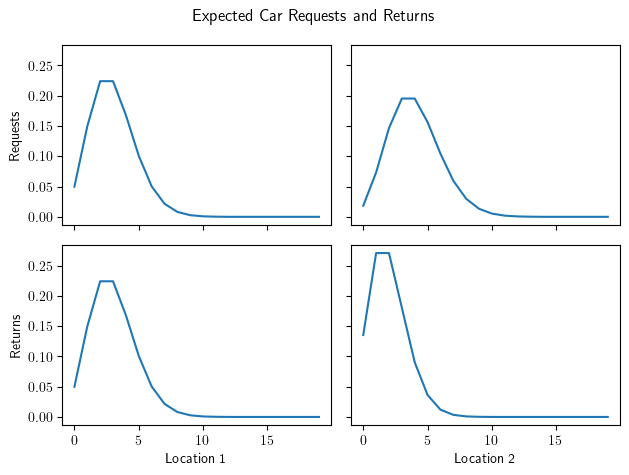

In [8]:
from itertools import count
from typing import Sequence
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson


class TruncatedPoisson:
    """A cache for Poisson PMF values.

    Only stores values of k for which pmf(k) > epsilon.
    """

    def __init__(
        self,
        mu: float,
        eps: float = 1e-4,
    ):
        """Initialize a new Poisson cache.

        Args:
            mu (float): the mean of the distribution.
            eps (float, optional): minimum PMF to be cached. Defaults to 1e-4.
        """
        self._mu = mu
        self._eps = eps
        self._lower = None
        self._upper = None
        self._pmf = []

        # underlying poisson from scipy
        rv = poisson(self._mu)

        for k in count(start=0):
            p = rv.pmf(k)
            if p > self._eps and self._lower is None:
                self._lower = k
                self._pmf.append(p)
            elif p < self._eps:
                break
            else:
                self._upper = k
                self._pmf.append(p)

        # normalize so that truncated PMF sums to 1
        self._pmf = np.array(self._pmf)
        self._pmf /= self._pmf.sum()
        self._k = np.arange(self._lower, self._upper + 1)

        print(
            f"TruncatedPoisson fitted: (mu={mu}, eps={eps}, lower={self._lower}, upper={self._upper})"
        )

    def k(self) -> Sequence[int]:
        """Return all values of k stored within this class."""
        return self._k

    def pmf(self, k: int) -> float:
        """Return the value of the Probability Mass Function computed for the given k.

        Args:
            k (int): Poisson observation.

        Returns:
            float: Probability that the given Poisson observation may occur.
        """
        if isinstance(k, np.ndarray):
            return np.take(self._pmf, k)
        if k not in self.k():
            return 0
        return self._pmf[k]


# create four Poisson distributions, for each location, and for requests/returns
requests_poisson = [TruncatedPoisson(mu=lam) for lam in config.requests_lambda]
returns_poisson = [TruncatedPoisson(mu=lam) for lam in config.returns_lambda]


# plot Poissons
def plot_poisson():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

    ns = range(20)
    axs[0, 0].plot(ns, [requests_poisson[0].pmf(n) for n in ns])
    axs[0, 1].plot(ns, [requests_poisson[1].pmf(n) for n in ns])
    axs[1, 0].plot(ns, [returns_poisson[0].pmf(n) for n in ns])
    axs[1, 1].plot(ns, [returns_poisson[1].pmf(n) for n in ns])

    axs[1, 0].set_xlabel("Location 1")
    axs[1, 1].set_xlabel("Location 2")
    axs[0, 0].set_ylabel("Requests")
    axs[1, 0].set_ylabel("Returns")

    fig.suptitle("Expected Car Requests and Returns")

    plt.tight_layout()
    plt.show()


plot_poisson()

#### World Model


In [9]:
def states():
    """Iterate through all states in the MDP.

    Yields:
        tuple[int, int]: A tuple of integers representing the count of cars at each location.
    """
    for s1 in range(config.max_cars + 1):
        for s2 in range(config.max_cars + 1):
            yield s1, s2


def actions(s: tuple[int, int]):
    """Iterate through all actions available at a given state in the MDP.

    -MAX_MOVES < ---------- | ---------- > +MAX_MOVES
    location 1              0              location 2

    Args:
        s (tuple[int, int]): the state

    Yields:
        int: An integer representing the flow of cars in the night. 0 means no cars have been moved.
             A negative integer represents moving cars from location 2 to location 1,
             A positive integer represents moving cars from location 1 to location 2.
    """
    # cannot move more cars than:
    #  - max number of moves
    #  - cars available at source
    #  - spaces available at destination
    lower_bound = max(-config.max_moves, -s[1], -(config.max_cars - s[0]))
    upper_bound = min(+config.max_moves, +s[0], +(config.max_cars - s[1]))
    for a in range(lower_bound, upper_bound + 1):
        yield a


def rv_observations():
    """Iterate over all possible observations of the four independent Poisson random variables.

    Yields:
        tuple[int, int, int, int]: An observation of the joint random variables, indicating the number of requests and
                                   returns occuring at each location.
    """
    for requests_1 in requests_poisson[0].k():
        for returns_1 in returns_poisson[0].k():
            for requests_2 in requests_poisson[1].k():
                for returns_2 in returns_poisson[1].k():
                    yield requests_1, requests_2, returns_1, returns_2

#### Policy Iteration


In [ ]:
# create a joint probability table for all possible observations of the four
# independent Poisson random variables. we only have to create this table once
# because it does not change during policy iteration
joint_probability = np.array(list(rv_observations()), dtype=int)  # [4; N]
req0, req1, ret0, ret1 = joint_probability.T  # [N; 4]
joint_probability = (
    requests_poisson[0].pmf(req0)
    * requests_poisson[1].pmf(req1)
    * returns_poisson[0].pmf(ret0)
    * returns_poisson[1].pmf(ret1)
)  # [N;]


def expected_return(s: tuple[int, int], a: int, V) -> float:
    """Compute the expected return when starting in a given state and taking a given action.

    The future return is approximated by the given value function, which is
    meant to represent the expected return when following the current policy.

    Args:
        s (tuple[int, int]): The starting state.
        a (int): The action taken.
        V: The value function that maps states to expected return when following policy pi.

    Returns:
        float: The expected return.
    """
    # assign cost for moving cars, this is deterministic
    move_reward = config.move_reward * abs(a)

    # move the cars during the night
    s_night = (s[0] - a, s[1] + a)

    # compute the number of rental requests that we can fulfill.
    # it must be the the minimum of:
    #  - number of cars available
    #  - number of requests
    fulfilled = (np.minimum(s_night[0], req0), np.minimum(s_night[1], req1))

    # compute the next state, given the movement of cars in/out
    # (note: cannot go over the max limit)
    s_next = (
        np.minimum(s_night[0] - fulfilled[0] + ret0, config.max_cars),
        np.minimum(s_night[1] - fulfilled[1] + ret1, config.max_cars),
    )

    # compute the reward for fulfilling car rental requests at each location
    rent_reward = config.rent_reward * (fulfilled[0] + fulfilled[1])

    # bellman equation to compute expected reward, we must iterate over all
    # possible (s', r) combinations
    # dot product => weighs values by probabilities and then sums => expectation
    expected_reward = joint_probability @ (rent_reward + config.gamma * V[s_next])

    # add deterministic move cost to expected reward from rentals
    return move_reward + expected_reward


def evaluation(V, pi, max_iter: int = 100, theta: float = 0.1):
    """Policy evaluation.

    This step stabilizes the value function to be consistent with the current policy.

    Args:
        V: Value function.
        pi: Policy function.
        max_iter (int, optional): _description_. Defaults to 100.
        theta (float, optional): _description_. Defaults to 0.1.
    """
    for _ in range(max_iter):
        delta = 0
        # V_new = np.zeros_like(V)
        for s in states():
            v = V[s]
            V[s] = expected_return(s, pi[s], V)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break


def improvement(V, pi):
    """Policy improvement.

    This step of policy iteration makes the policy greedy w.r.t. the current value function.

    Args:
        V: Value function.
        pi: Policy function.

    Returns:
        bool: Whether the policy is stable (was changed or not during improvement).
    """
    policy_stable = True
    for s in states():
        old_a = pi[s]
        best_a, best_v = pi[s], V[s]
        for a in actions(s):
            if a == old_a:
                continue
            v = expected_return(s, a, V)
            if v > best_v:
                best_a, best_v = a, v
        pi[s] = best_a
        if pi[s] != old_a:
            policy_stable = False
    return policy_stable


def policy_iteration(V, pi, max_iter: int = 4):
    """Run policy iteration, from Sutton and Barto.

    This function mutates the given parameters for V and pi.

    Args:
        V: Value function.
        pi: Policy function.
        max_iter (int, optional): Maximum number of iterations.

    Yields:
        int: the current iteration index.
    """
    for i in range(max_iter):
        evaluation(V, pi)
        policy_stable = improvement(V, pi)
        yield i + 1
        if policy_stable:
            return

#### Plotting Utilities


In [11]:
import os
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True


def plot_V(V, i):
    """Plot the value function at iteration i and save to figs/value_{i}.png."""
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(V, cmap="viridis")
    ax.invert_yaxis()
    ax.set_title(rf"$V_{{{i}}}$")
    fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

    plt.xlabel("Number of cars at location 1")
    plt.ylabel("Number of cars at location 2", rotation=90)

    nx, ny = V.shape[1], V.shape[0]
    ax.set_xticks(np.arange(0, nx, 5))
    ax.set_yticks(np.arange(0, ny, 5))

    plt.tight_layout()
    os.makedirs("figs", exist_ok=True)
    fig.savefig(f"figs/value_{i}.png")
    plt.show()


def plot_pi(pi, i):
    """Plot the policy at iteration i and save to figs/pi_{i}.png."""
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(pi, cmap="viridis")
    ax.invert_yaxis()
    ax.set_title(rf"$\pi_{{{i}}}$")
    fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

    plt.xlabel("Number of cars at location 1")
    plt.ylabel("Number of cars at location 2", rotation=90)

    nx, ny = pi.shape[1], pi.shape[0]
    ax.set_xticks(np.arange(0, nx, 5))
    ax.set_yticks(np.arange(0, ny, 5))

    plt.tight_layout()
    os.makedirs("figs", exist_ok=True)
    fig.savefig(f"figs/pi_{i}.png")
    plt.show()

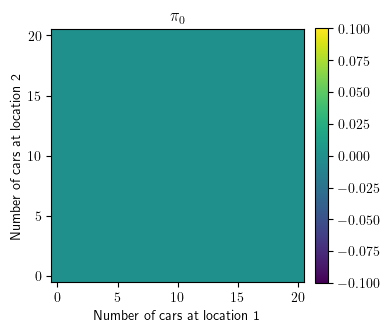

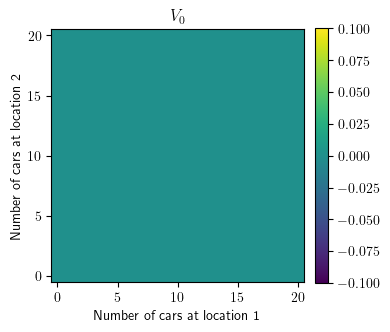

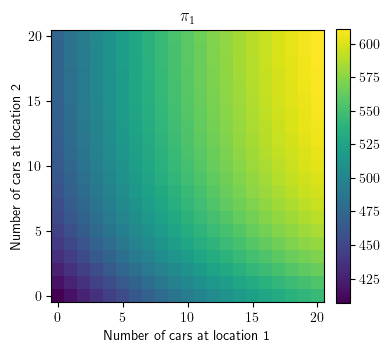

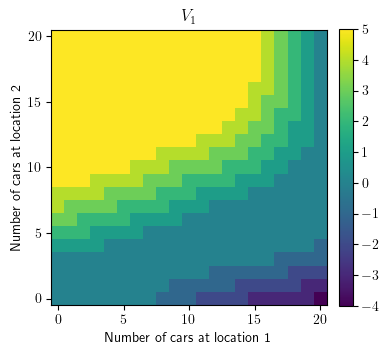

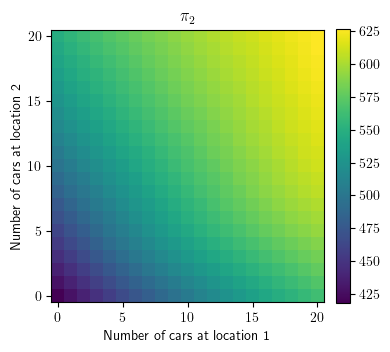

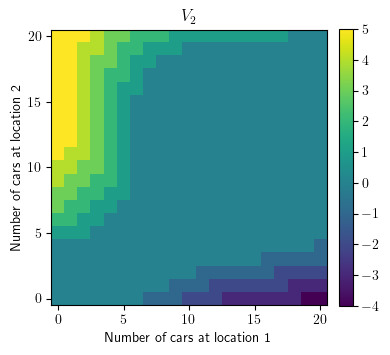

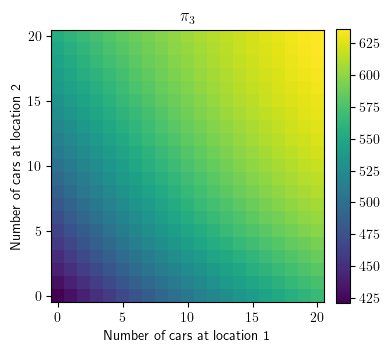

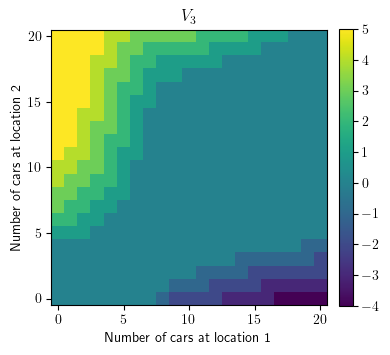

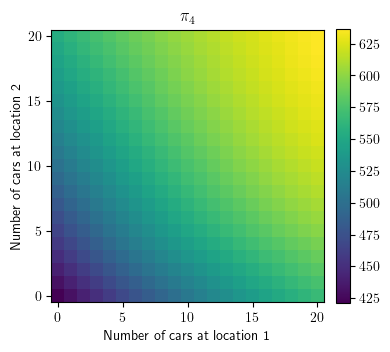

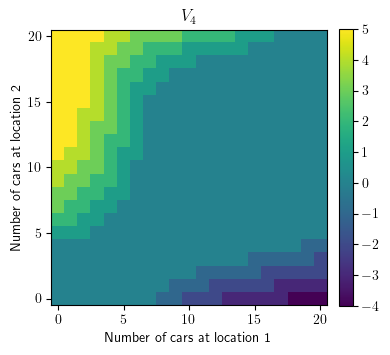

In [12]:
# initialize value function and policy table
V = np.zeros((config.max_cars + 1, config.max_cars + 1), dtype=float)
pi = np.zeros((config.max_cars + 1, config.max_cars + 1), dtype=int)

# run policy iteration, plot policy and value function after each iteration
plot_pi(pi, 0)
plot_V(V, 0)
for i in policy_iteration(V, pi):
    plot_pi(V, i)
    plot_V(pi, i)